<a href="https://colab.research.google.com/github/kootr/ml-study-session/blob/main/bq_arima_multiple_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA model 
参考にしたTutorial  https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-multivariate-time-series

In [ ]:
from google.cloud import bigquery
import pandas as pd

In [ ]:
# GCP認証　(VertexAI workbench：必要なし、Googole collabo:必要、ローカル: 必要（Jsonクレデンシャルファイルを配置する）　)
import os
import sys

IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules: # もしVertex AI workbench　なら何も必要なし
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # どれも当てはまらない場合はローカル実行として、クレデンシャルファイルを指定
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS '/<<location_to>>/key_file.json'

### シアトルの大気データを用いた多変量時系列予測

In [ ]:
# 変数の定義
project_id = "ml-session"
client = bigquery.Client(location="US", project=project_id)
model_name = "seattle_pm25_xreg_model"
dataset_id = "session20"
datasets = list(client.list_datasets(project_id))
create_table_seattle_air = "seattle_air_quality_daily"

In [ ]:
# 既存のデータセットを確認し、新規データセットを作成
if datasets:
    print(f"Datasets in project {project_id}")
    for dataset in datasets:
        print(f"{dataset.dataset_id}")

dataset = bigquery.Dataset(f'{project_id}.{dataset_id}')

dataset.location = "US"

dataset = client.create_dataset(dataset)  # Make an API request.
print(f"Created dataset: {dataset_id} in {project_id}")

Datasets in project ml-session
session18
session19
session20
Created dataset: session20 in ml-session


## 3つのパブリックのテーブル

In [ ]:
query = "SELECT * FROM bigquery-public-data.epa_historical_air_quality.pm25_nonfrm_daily_summary LIMIT 5"
query_job = client.query(
    query,
    location="US",
)
df_pm25 = query_job.to_dataframe()
df_pm25.head(1)

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,...,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,12,086,0030,88502,1,25.39122,-80.680819,WGS84,Acceptable PM2.5 AQI & Speciation Mass,24 HOUR,...,35,707,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,SITE MOVED ACROSS ROAD FROM BEARD CENTER TO BE...,EVERGLADES NP,Florida,Miami-Dade,Not in a city,"Miami-Fort Lauderdale-West Palm Beach, FL",2015-07-22


In [ ]:
query = "SELECT * FROM bigquery-public-data.epa_historical_air_quality.temperature_daily_summary LIMIT 5"
query_job = client.query(
    query,
    location="US",
)
df_temp = query_job.to_dataframe()
df_temp.head(1)

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,...,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,38,057,0102,62101,1,47.325,-101.765833,NAD27,Outdoor Temperature,1 HOUR,...,<NA>,41,INSTRUMENTAL - ELEC. OR MACH. AVG. LEVEL 1,609 60TH AVE. SW,DGC #12,North Dakota,Mercer,Not in a city,None,2013-06-11


In [ ]:
query = "SELECT * FROM bigquery-public-data.epa_historical_air_quality.wind_daily_summary LIMIT 5"
query_job = client.query(
    query,
    location="US",
)
df_air = query_job.to_dataframe()
df_air.head(1)

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,...,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,17,043,6001,61103,1,41.813049,-88.072827,WGS84,Wind Speed - Resultant,1 HOUR,...,<NA>,20,INSTRUMENTAL - VECTOR SUMMATION,MORTON ARBORETUM,RT. 53,Illinois,DuPage,Lisle,"Chicago-Naperville-Elgin, IL-IN-WI",2016-05-14


In [ ]:
# 以下の3つのパブリックのテーブルを結合し、シアトルの日次データのみのテーブルを作成する。
# 2009/8/11 ~ 2022/1/31

# `bigquery-public-data.epa_historical_air_quality.pm25_nonfrm_daily_summary`  : pm2.5濃度
# `bigquery-public-data.epa_historical_air_quality.temperature_daily_summary`: 気温
# `bigquery-public-data.epa_historical_air_quality.wind_daily_summary` : 風速


create_query = f"""
#standardSQL
CREATE TABLE `{project_id}.{dataset_id}.{create_table_seattle_air}` IF NOT EXISTS
AS
WITH
  pm25_daily AS (
    SELECT
      avg(arithmetic_mean) AS pm25, date_local AS date
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_nonfrm_daily_summary` -- パブリックテーブル
    WHERE
      city_name = 'Seattle'
      AND parameter_name = 'Acceptable PM2.5 AQI & Speciation Mass'
    GROUP BY date_local
  ),
  wind_speed_daily AS (
    SELECT
      avg(arithmetic_mean) AS wind_speed, date_local AS date
    FROM
      `bigquery-public-data.epa_historical_air_quality.wind_daily_summary`　 -- パブリックテーブル
    WHERE
      city_name = 'Seattle' AND parameter_name = 'Wind Speed - Resultant'
    GROUP BY date_local
  ),
  temperature_daily AS (
    SELECT
      avg(first_max_value) AS temperature, date_local AS date
    FROM
      `bigquery-public-data.epa_historical_air_quality.temperature_daily_summary`　 -- パブリックテーブル
    WHERE
      city_name = 'Seattle' AND parameter_name = 'Outdoor Temperature'
    GROUP BY date_local
  )
SELECT
  pm25_daily.date AS date, pm25, wind_speed, temperature
FROM pm25_daily
JOIN wind_speed_daily USING (date)
JOIN temperature_daily USING (date)
"""
query_job = client.query(
    query,
     location="US",
)


In [ ]:
select_query = f"SELECT * FROM {project_id}.{dataset_id}.{create_table_seattle_air} WHERE date > DATE('2018-12-31') ORDER BY date"

query_job = client.query(
    select_query,
    location="US",
)

df_seattle_air = query_job.to_dataframe()
df_seattle_air.head()

,date,pm25,wind_speed,temperature
0,2019-01-01,19.220833,1.352083,42.5
1,2019-01-02,10.708333,3.256250,46.5
2,2019-01-03,8.361111,4.256250,55.0
3,2019-01-04,6.229166,6.093750,50.5
4,2019-01-05,10.420834,1.889583,49.5


date: 観測日

PM2.5: 各日の PM2.5 の平均値

wind_speed: 各日の平均風速

temperature: 各日の最高気温

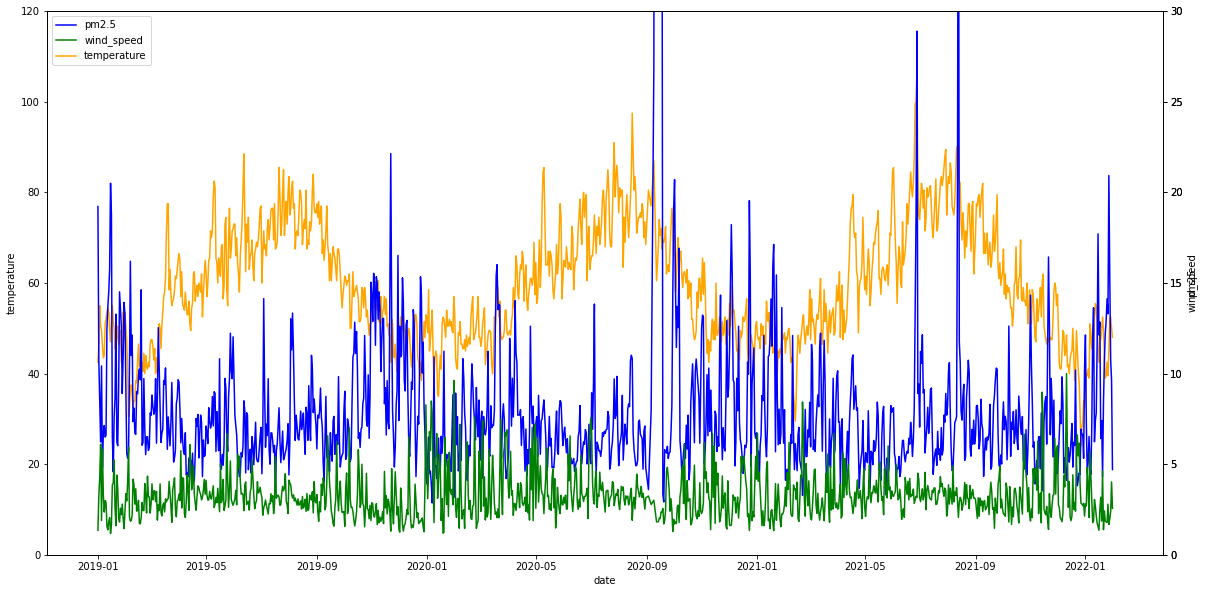

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20, 10), facecolor="w")


# ax2 = fig.subplots()
ax3 = fig.subplots()
ax1 = ax3.twinx()
# ax1のx軸をコピー
ax２ = ax3.twinx()
ax1.set_ylim(0, 30)
ax2.set_ylim(0, 30)
ax3.set_ylim(0, 120)

sns.lineplot(x='date', y='pm25', ax=ax1, data=df_seattle_air, label='pm2.5', color='blue')
sns.lineplot(x='date', y='wind_speed',ax=ax2, data=df_seattle_air, label='wind_speed', color='green')
sns.lineplot(x='date', y='temperature',ax=ax3, data=df_seattle_air, label='temperature', color='orange')


# 凡例を取得
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
handler3, label3 = ax3.get_legend_handles_labels()
# ax1で凡例をまとめて表示
ax1.legend(handler1 + handler2 + handler3, label1 + label2 + label3, loc="upper left")
# ax2の凡例は削除
ax2.get_legend().remove()
ax3.get_legend().remove()

plt.show()

## ToDo: グラフをきれいにする

In [ ]:
# 以下のクエリを実行するにはスロットの購入が必要。
# https://cloud.google.com/bigquery/docs/reservations-intro?hl=ja
# スロット購入の際はFlexプランの選択が妥当。実行後、スロットを削除する。
# コミットメント(Flex)作成→予約作成→予約割り当て作成→クエリ実行→予約割り当て削除→予約削除→スロットコミットメント削除


In [ ]:
# 2012/1/1 ~ 2020/12/31 のデータを学習に使用
query = f"""
#standardSQL
CREATE OR REPLACE
  MODEL
    `{project_id}.{dataset_id}.{model_name}`
  OPTIONS (
    MODEL_TYPE = 'ARIMA_PLUS_XREG',
    time_series_timestamp_col = 'date',
    time_series_data_col = 'pm25')
AS
SELECT
  date,
  pm25,
  temperature,
  wind_speed
FROM
  `{project_id}.{dataset_id}.{create_table_seattle_air}`
WHERE
  date
  BETWEEN DATE('2012-01-01')
  AND DATE('2020-12-31')
  """

query_job = client.query(
    query,
    location="US",
)

In [ ]:
# ARIMAモデルの評価
query = f"""
SELECT
 *
FROM
 ML.ARIMA_EVALUATE(MODEL `{project_id}.{dataset_id}.{model_name}`)
  """

query_job = client.query(
    query,
    location="US",
)
df_arima_evaluate_model = query_job.to_dataframe()
df_arima_evaluate_model.head()

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,0,1,5,False,-7000.451786,14012.903572,4.136466,[WEEKLY],False,True,True,
1,0,1,5,True,-7000.245848,14014.491696,4.135934,[WEEKLY],False,True,True,
2,1,1,4,False,-7111.859773,14235.719547,4.432092,[WEEKLY],False,True,True,
3,4,1,1,False,-7112.018794,14236.037589,4.432532,[WEEKLY],False,True,True,
4,1,1,4,True,-7111.529790,14237.059580,4.431166,[WEEKLY],False,True,True,


In [ ]:
# non_seasonal_{p,d,q}、has_drift: ARIMA モデルを定義
# log_likelihood、AIC、variance    : ARIMA モデルの評価
# AIC が最小のモデルを採用する。

In [ ]:
# モデルの係数を調べる

query = f"""
SELECT
 *
FROM
 ML.ARIMA_COEFFICIENTS(MODEL `{project_id}.{dataset_id}.{model_name}`)
  """

query_job = client.query(
    query,
    location="US",
)
df_coefficients = query_job.to_dataframe()
df_coefficients.head()

,ar_coefficients,ma_coefficients,intercept_or_drift,processed_input,weight,category_weights
0,[],[],NaN,temperature,0.038278,[]
1,[],[],NaN,wind_speed,-1.957316,[]
2,[],[],NaN,__INTERCEPT__,11.324378,[]
3,[],"[-0.40998375734253784, -0.6807758057982711, 0....",0.0,None,NaN,[]


In [ ]:
# processed_input と対応する weight 列と category_weights 列に、線形回帰モデルの各特徴とインターセプトの重みが表示されます。
# ar_coefficients は、ARIMA モデルの自己回帰（AR）部分のモデル係数
# ma_coefficients は移動平均（MA）部分のモデル係数
# ML.ARIMA_EVALUATE の出力から、最もAICが小さいモデルの non_seasonal_p は 0 で、non_seasonal_q は 5 なので、上の結果と一致

In [ ]:
# 予測精度を評価
# create_table_seattle_air = "seattle_air_quality_daily"
query = f"""
SELECT
*
FROM
ML.EVALUATE(
MODEL `{project_id}.{dataset_id}.{model_name}`,
(
  SELECT
    date,
    pm25,
    temperature,
    wind_speed
  FROM
    `{project_id}.{dataset_id}.{create_table_seattle_air}`
  WHERE
    date > DATE('2020-12-31')
),
STRUCT(
  TRUE AS perform_aggregation,
  30 AS horizon))
  """

query_job = client.query(
    query,
    location="US",
)
df_evaluate_model = query_job.to_dataframe()
df_evaluate_model.head()

,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,2.532517,9.730194,3.119326,30.258432,27.0185


In [ ]:
# 予測データ (2021-1-1 ~ 2021-1-30)

query = f"""
#standardSQL
SELECT
*
FROM
ML.FORECAST(
MODEL `{project_id}.{dataset_id}.{model_name}`,
STRUCT(30 AS horizon, 0.8 AS confidence_level),
(
  SELECT
    date,
    temperature,
    wind_speed
  FROM
    `{project_id}.{dataset_id}.{create_table_seattle_air}`
  WHERE
    date > DATE('2020-12-31')
))
  """

query_job = client.query(
    query,
    location="US",
)
df_forecast = query_job.to_dataframe()
df_forecast.head()

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2021-01-01 00:00:00+00:00,9.497004,2.033830,0.8,6.889051,12.104958
1,2021-01-02 00:00:00+00:00,4.653183,2.361451,0.8,1.625126,7.681239
2,2021-01-03 00:00:00+00:00,8.667039,2.368654,0.8,5.629746,11.704333
3,2021-01-04 00:00:00+00:00,6.518647,2.569179,0.8,3.224223,9.813072
4,2021-01-05 00:00:00+00:00,7.524840,3.107138,0.8,3.540599,11.509081


In [ ]:
# 実際のデータ (2021-1-1 ~ 2021-1-30)
query = f"""
  SELECT
    date,
    pm25
  FROM
    `{project_id}.{dataset_id}.{create_table_seattle_air}`
  WHERE
    date > DATE('2020-12-31')
    AND date < DATE('2021-1-31')
  """

query_job = client.query(
    query,
    location="US",
)
df_actual = query_job.to_dataframe()
df_actual.head()

,date,pm25
0,2021-01-24,8.737500
1,2021-01-16,12.018750
2,2021-01-18,11.519565
3,2021-01-04,4.085869
4,2021-01-12,5.410417


In [ ]:
df_forecast

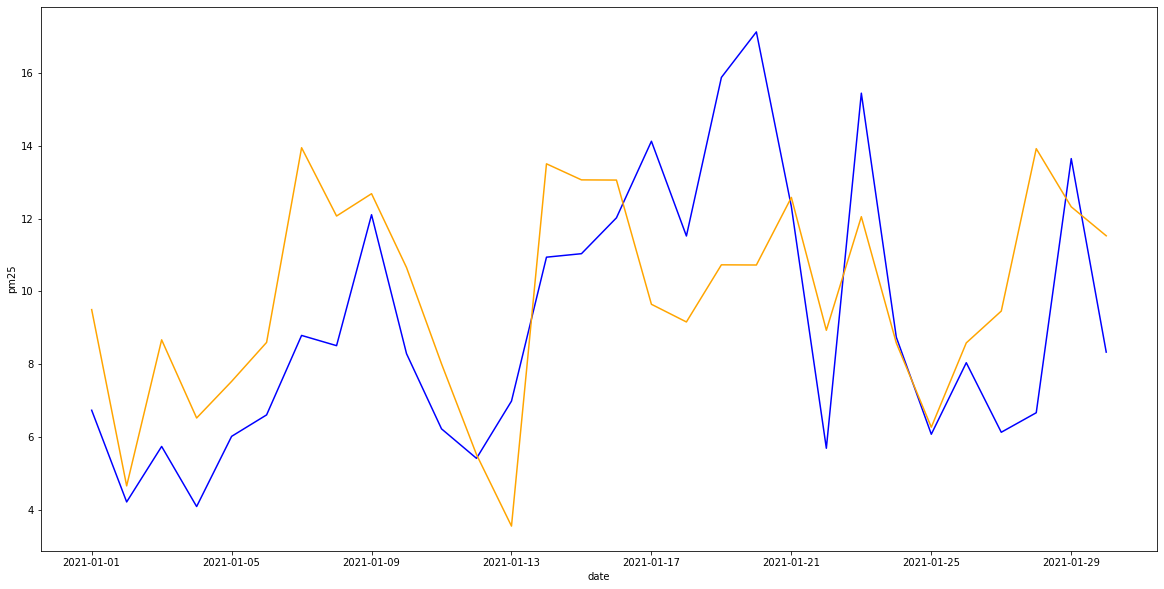

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(20, 10), facecolor="w")

sns.lineplot(x='date', y='pm25', data=df_actual, color='blue')
sns.lineplot(x='forecast_timestamp', y='forecast_value', data=df_forecast, color='orange')

plt.show()



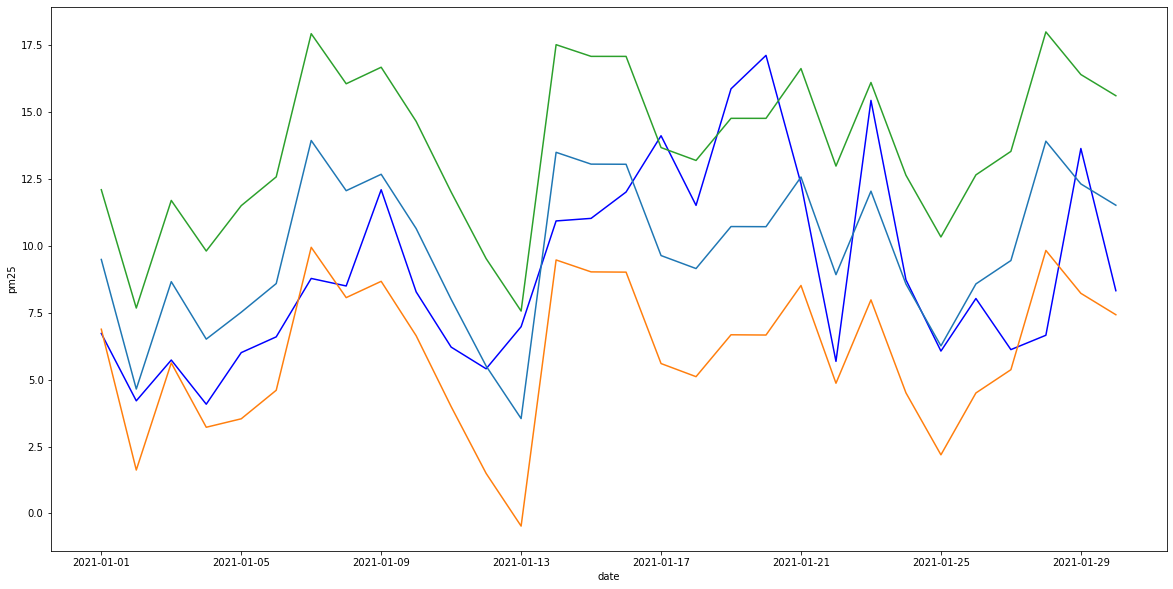

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20, 10), facecolor="w")


# # ax2 = fig.subplots()
# ax4 = fig.subplots()
# # ax1のx軸をコピー
# ax4.set_ylim(0, 20)

# sns.lineplot(x='date', y='pm25', ax=ax4, data=df_actual, color='blue')
# sns.lineplot(x='forecast_timestamp', ax=ax4, y='forecast_value', data=df_forecast)
# sns.lineplot(x='forecast_timestamp', ax=ax4, y='prediction_interval_lower_bound', data=df_forecast)
# sns.lineplot(x='forecast_timestamp', ax=ax4, y='prediction_interval_upper_bound', data=df_forecast)


sns.lineplot(x='date', y='pm25', data=df_actual, color='blue')
sns.lineplot(x='forecast_timestamp', y='forecast_value', data=df_forecast)
sns.lineplot(x='forecast_timestamp', y='prediction_interval_lower_bound', data=df_forecast)
sns.lineplot(x='forecast_timestamp', y='prediction_interval_upper_bound', data=df_forecast)


# # 凡例を取得
handler4, label4 = ax4.get_legend_handles_labels()
# handler2, label2 = ax2.get_legend_handles_labels()
# handler3, label3 = ax3.get_legend_handles_labels()
# # ax1で凡例をまとめて表示
# ax1.legend(handler1 + handler2 + handler3, label1 + label2 + label3, loc="upper left")
# # ax2の凡例は削除
# ax2.get_legend().remove()
# ax3.get_legend().remove()

plt.show()